In [20]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
import torch
import os

import sys
sys.path.insert(0, '../trainingdata')
from datasaver import *
sys.path.insert(0, '../testproblems/tdarcy')
from manufacturedsolutions import *
sys.path.insert(0, '../ml')
from modelloader import loadmodelfromlabel
from NeuralOperator import NeuralOperator
from customlosses import *
from quadrature import *
from customlayers import discretize_functions
from basisfunctions import *

In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
from NeuralOperator import NeuralOperator

logdir = '../../../nnlogs'
device = 'cuda:3'

sublogdir = 'tdd'

projection = loadmodelfromlabel(model=NeuralOperator, label='modelNGO', logdir=logdir, sublogdir=sublogdir, device=device)
projection.hparams['modeltype'] = 'projection'
projection.hparams['dtype'] = torch.float64
projection.hparams['Dt'] = 0.001
projection.hparams['Q'] = (2,99,99)
projection.__init__(projection.hparams)

FEM = loadmodelfromlabel(model=NeuralOperator, label='modelNGO', logdir=logdir, sublogdir=sublogdir, device=device)
FEM.hparams['modeltype'] = 'FEM'
FEM.hparams['dtype'] = torch.float64
FEM.hparams['Neumannseries'] = False
FEM.hparams['Neumannseries_order'] = None
FEM.hparams['project_materialparameters'] = False
FEM.hparams['project_rhs'] = False
FEM.hparams['gamma_stabilization'] = 0
FEM.hparams['Dt'] = 0.001
FEM.hparams['Q'] = (2,99,99)
FEM.__init__(FEM.hparams)

stabFEM = loadmodelfromlabel(model=NeuralOperator, label='modelNGO', logdir=logdir, sublogdir=sublogdir, device=device)
stabFEM.hparams['modeltype'] = 'FEM'
stabFEM.hparams['dtype'] = torch.float64
stabFEM.hparams['Neumannseries'] = False
stabFEM.hparams['Neumannseries_order'] = None
stabFEM.hparams['project_materialparameters'] = False
stabFEM.hparams['project_rhs'] = False
stabFEM.hparams['gamma_stabilization'] = 100
stabFEM.hparams['Dt'] = 0.001
stabFEM.hparams['Q'] = (2,99,99)
stabFEM.__init__(stabFEM.hparams)

# FEM_projrhs = loadmodelfromlabel(model=NeuralOperator, label='modelNGO', logdir=logdir, sublogdir=sublogdir, device=device)
# FEM_projrhs.hparams['modeltype'] = 'FEM'
# FEM_projrhs.hparams['dtype'] = torch.float64
# FEM_projrhs.hparams['Neumannseries'] = False
# FEM_projrhs.hparams['Neumannseries_order'] = None
# FEM_projrhs.hparams['project_materialparameters'] = True
# FEM_projrhs.hparams['project_rhs'] = True
# FEM_projrhs.hparams['gamma_stabilization'] = 0
# FEM_projrhs.hparams['Dt'] = 0.01
# FEM_projrhs.__init__(FEM_projrhs.hparams)

# NN = loadmodelfromlabel(model=NeuralOperator, label='NN', logdir=logdir, sublogdir=sublogdir, device=device)

# FNO = loadmodelfromlabel(model=NeuralOperator, label='FNO', logdir=logdir, sublogdir=sublogdir, device=device)

# DeepONet = loadmodelfromlabel(model=NeuralOperator, label='DeepONet', logdir=logdir, sublogdir=sublogdir, device=device)

# VarMiON = loadmodelfromlabel(model=NeuralOperator, label='VarMiON', logdir=logdir, sublogdir=sublogdir, device=device)

# dataNGO = loadmodelfromlabel(model=NeuralOperator, label='dataNGO', logdir=logdir, sublogdir=sublogdir, device=device)

# dataNGO_C = loadmodelfromlabel(model=NeuralOperator, label='dataNGO_C', logdir=logdir, sublogdir=sublogdir, device=device)

# datafreeNGO = loadmodelfromlabel(model=NeuralOperator, label='datafreeNGO', logdir=logdir, sublogdir=sublogdir, device=device)

# datafreeNGO_C = loadmodelfromlabel(model=NeuralOperator, label='datafreeNGO_C', logdir=logdir, sublogdir=sublogdir, device=device)

# modelNGO = loadmodelfromlabel(model=NeuralOperator, label='modelNGO', logdir=logdir, sublogdir=sublogdir, device=device)

# modelNGO_C = loadmodelfromlabel(model=NeuralOperator, label='modelNGO_C', logdir=logdir, sublogdir=sublogdir, device=device)

modeldict = {'Projection': projection,
             'FEM': FEM,
             'FEM $\gamma=100$': stabFEM}
            #   'NN': NN,
            #   'FNO': FNO,
            #   'DeepONet': DeepONet,
            #  'VarMiON': VarMiON,
            # #'Data NGO': dataNGO,
            # 'Data NGO (m)': dataNGO_C,
            # #'Data-free NGO': datafreeNGO,
            # 'Data-free NGO (m)': datafreeNGO_C,
            # #'Model NGO': modelNGO,
            # 'Model NGO (m)': modelNGO_C}

Projection
FEM
FEM $\gamma=100$


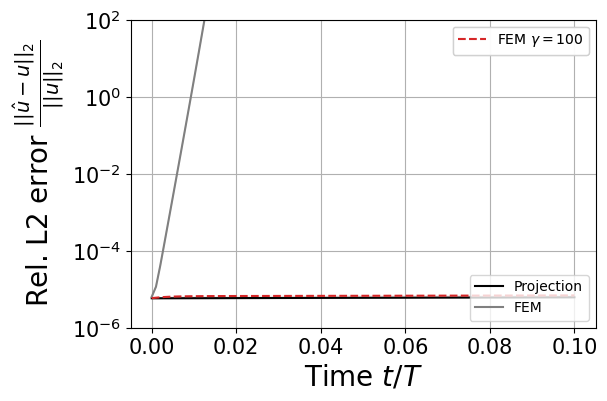

In [26]:
N_samples = 1
n_timesteps = 100
t_values = np.linspace(0,n_timesteps*projection.hparams['Dt'],n_timesteps)

alpha = 0.05
q_low = alpha/2
q_high = 1 - q_low

L2_scaled_avg = np.zeros((len(modeldict),n_timesteps))
yerr = np.zeros((len(modeldict),2,n_timesteps))

size_title = 20
size_ticklabels = 15
size_axeslabels = 20

# quadrature = GaussLegendreQuadrature(n_elements=[1,3,3], Q=[1,30,30])
quadrature = UniformQuadrature(Q=[3,30,30])
x = quadrature.xi
w = quadrature.w
w = w*projection.hparams['Dt']

linestyles=['-','-','--','--','--','--','--','--','--','--','--','--','--','--','--']
colors = ['black','grey','C0','C1','C2','C3','C4','C5','C6','C7','C8']

linestyles=['-','-','--','--','--','--','--','--','--','--','--']
colors = ['black','grey','C3','C6','C4','C5','C0','C1','C2']

# dataset = ManufacturedSolutionsSet(N_samples=N_samples, variables=['t','x','x'], l_min=[1,1,1], l_max=[1,1,1])
# theta = dataset.theta
# f = dataset.f
# etat = dataset.etat
# etab = dataset.etab
# gl = dataset.gl
# gr = dataset.gr
# u = dataset.u
# u0 = dataset.u0

m=0
for model in modeldict:
    print(str(model))
    modeldict[str(model)].timestep = 0
    x_scaled = np.copy(x)
    x_scaled[:,0] = x_scaled[:,0]*modeldict[str(model)].hparams['Dt']

    for i in range(n_timesteps):
        u_exact = discretize_functions(u, x_scaled)
        u_hat = modeldict[str(model)].simforward(theta, f, etab, etat, gl, gr, u0, x, u)
        L2_scaled_array = weightedrelativeL2_set(w, u_hat, u_exact)
        L2_scaled_avg[m,i] = np.average(L2_scaled_array)
        q_l = np.quantile(L2_scaled_array, q_low)
        q_h = np.quantile(L2_scaled_array, q_high)
        yerr[m,:,i] = np.array([q_l, q_h])
        modeldict[str(model)].translate_quadrature_t()
        x_scaled[:,0] = x_scaled[:,0] + modeldict[str(model)].hparams['Dt']
        modeldict[str(model)].timestep += 1
    m+=1

fig, ax = plt.subplots(1,1, figsize=(6, 4))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)

plots = []
m=0
ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.set_xlabel(r'Time $t/T$', fontsize=size_axeslabels)
ax.set_ylabel(r'Rel. L2 error $\frac{||\hat{u}-u||_2}{||u||_2}$', fontsize=size_axeslabels)
ax.set_yscale('log')
# ax.set_xlim(0, 1.05)
ax.set_ylim(1e-6,1e2)

# ax.set_yticks([1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1,1e2])
ax.grid()
for model in modeldict:
    # plots.append(ax.errorbar(t_values, L2_scaled_avg[m], yerr=yerr[m], fmt=".-", capsize=6, ms=15, label=str(model), color=colors[m], linestyle=linestyles[m]))
    plots.append(ax.plot(t_values, L2_scaled_avg[m], label=str(model), color=colors[m], linestyle=linestyles[m])[0])
    ax.fill_between(t_values, yerr[m,0,:], yerr[m,1,:], alpha=0.1, color=colors[m])
    m+=1
# plt.legend(fontsize=10, ncols=2, loc='lower right')
legend1 = ax.legend(handles=plots[0:2],fontsize=10, ncols=1, loc='lower right')
plt.gca().add_artist(legend1)
legend2 = ax.legend(handles=plots[2:],fontsize=10, ncols=2, loc='upper right')
plt.gca().add_artist(legend2)

# plt.savefig("errorovertime_Dt1e-3.svg", bbox_inches='tight')#, transparent=True)

plt.show()

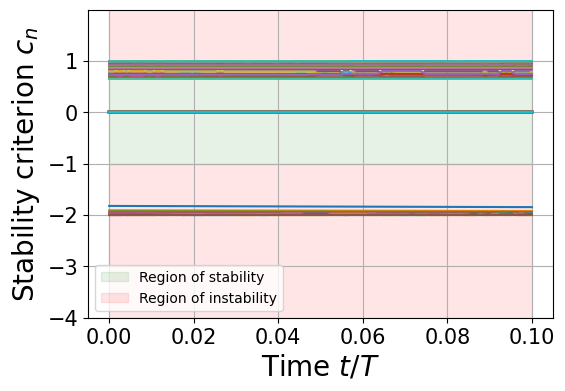

In [140]:
N_samples = 1
n_timesteps = 100
t_values = np.linspace(0,n_timesteps*projection.hparams['Dt'],n_timesteps)

alpha = 0.05
q_low = alpha/2
q_high = 1 - q_low

criterion = np.zeros((n_timesteps,projection.hparams['N']))

size_title = 20
size_ticklabels = 15
size_axeslabels = 20

# quadrature = GaussLegendreQuadrature(n_elements=[1,3,3], Q=[1,30,30])
quadrature = UniformQuadrature(Q=[3,30,30])
x = quadrature.xi
w = quadrature.w
w = w*projection.hparams['Dt']

linestyles=['-','-','--','--','--','--','--','--','--','--','--','--','--','--','--']
colors = ['black','grey','C0','C1','C2','C3','C4','C5','C6','C7','C8']

linestyles=['-','-','--','--','--','--','--','--','--','--','--']
colors = ['black','grey','C3','C6','C4','C5','C0','C1','C2']

dataset = ManufacturedSolutionsSet(N_samples=N_samples, variables=['t','x','x'], l_min=[1,1,1], l_max=[1,1,1])
theta = dataset.theta
f = dataset.f
etat = dataset.etat
etab = dataset.etab
gl = dataset.gl
gr = dataset.gr
u = dataset.u
u0 = dataset.u0

FEM = loadmodelfromlabel(model=NeuralOperator, label='modelNGO', logdir=logdir, sublogdir=sublogdir, device=device)
FEM.hparams['modeltype'] = 'FEM'
FEM.hparams['dtype'] = torch.float64
FEM.hparams['Neumannseries'] = False
FEM.hparams['Neumannseries_order'] = None
FEM.hparams['project_materialparameters'] = False
FEM.hparams['project_rhs'] = False
FEM.hparams['gamma_stabilization'] = 0
FEM.hparams['Dt'] = 0.001
FEM.hparams['Q'] = (2,99,99)
FEM.__init__(FEM.hparams)

for i in range(n_timesteps):
    criterion[i] = FEM.compute_stability_criterion(theta)
    FEM.translate_quadrature_t()
    FEM.timestep += 1

fig, ax = plt.subplots(1,1, figsize=(6, 4))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)

plots = []
m=0
ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.set_xlabel(r'Time $t/T$', fontsize=size_axeslabels)
ax.set_ylabel(r'Stability criterion $c_n$', fontsize=size_axeslabels)
# ax.set_yscale('log')
# ax.set_xlim(0, 1.05)
# ax.set_ylim(1e-6,1e2)

# ax.set_yticks([1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1,1e2])
ax.grid()
plots.append(ax.plot(t_values, criterion)[0])
y_treshold = 1
ax.fill_between(t_values, 1, 10*np.amax(criterion), color='red', alpha=0.1)
ax.fill_between(t_values, -1, 1, color='green', alpha=0.1, label='Region of stability')
ax.fill_between(t_values, 10*np.amin(criterion), -1, color='red', alpha=0.1, label='Region of instability')

ax.set_ylim(2*np.amin(criterion),2*np.amax(criterion))
# ax.fill_between(t_values, yerr[m,0,:], yerr[m,1,:], alpha=0.1, color=colors[m])
plt.legend(fontsize=10)
# legend1 = ax.legend(handles=plots[0:2],fontsize=10, ncols=1, loc='lower right')
# plt.gca().add_artist(legend1)
# legend2 = ax.legend(handles=plots[2:],fontsize=10, ncols=2, loc='upper right')
# plt.gca().add_artist(legend2)

plt.savefig("Dt1e-3.svg", bbox_inches='tight')#, transparent=True)

plt.show()

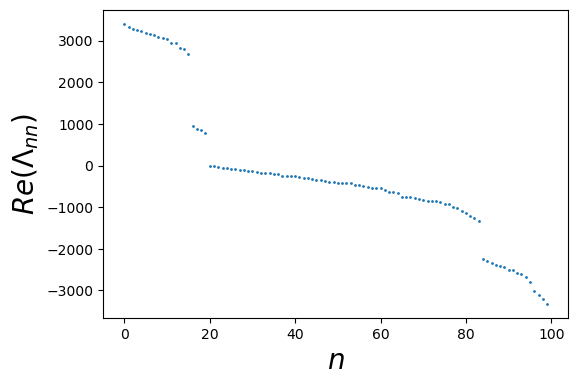

In [83]:
# Lambda = np.load('Lambda.npy')[0]

size_title = 20
size_ticklabels = 10
size_axeslabels = 20

fig, ax = plt.subplots(1,1, figsize=(6, 4))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)

ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.set_xlabel(r'$n$', fontsize=size_axeslabels)
ax.set_ylabel("$Re(\Lambda_{nn})$", fontsize=size_axeslabels)
# ax.set_xscale('log')
ax.scatter(np.linspace(0,len(Lambda)-1, len(Lambda)), np.flip(np.sort(Lambda)), s=1)
plt.savefig("eigvals.svg", bbox_inches='tight')#, transparent=True)
plt.show()

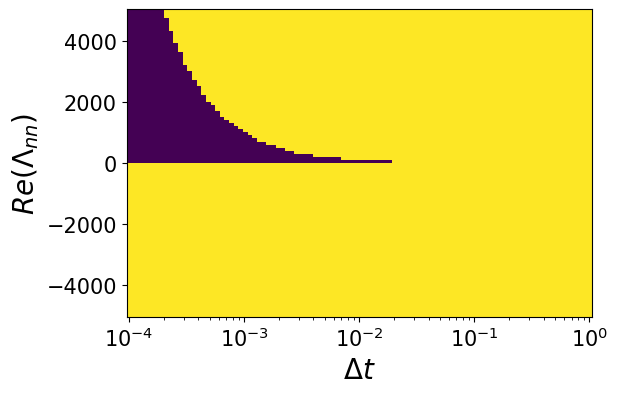

In [69]:
# Define the range and number of points
x_min, x_max = 1e-4, 1  # x values in log scale
y_min, y_max = -5e3, 5e3   # y values in linear scale
num_x = 100  # Number of points along x
num_y = 100  # Number of points along y

# Create x values on a logarithmic scale
Dt = np.logspace(np.log10(x_min), np.log10(x_max), num_x)

# Create y values on a linear scale
Lambda_nn_real = np.linspace(y_min, y_max, num_y)

# Create the meshgrid
Dt, Lambda_nn_real = np.meshgrid(Dt, Lambda_nn_real)

sc = np.sqrt(1 - Dt*Lambda_nn_real + (Dt**2)*(Lambda_nn_real**2))>1

fig, ax = plt.subplots(1,1, figsize=(6, 4))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)

ax.tick_params(axis='both', labelsize=size_ticklabels)
ax.set_xlabel(r'$\Delta t$', fontsize=size_axeslabels)
ax.set_ylabel("$Re(\Lambda_{nn})$", fontsize=size_axeslabels)

ax.set_xscale('log')
ax.pcolormesh(Dt, Lambda_nn_real, sc, shading='auto')
plt.savefig("stability.svg", bbox_inches='tight')#, transparent=True)
plt.show()